---

<h1> P8: Déployez un modèle dans le cloud (Big Data) <span class="tocSkip"></span></h1>

---


Lérys Granado, PhD <br> Sept 2021

## Notes

### Enoncés OC

Vous êtes donc chargé de **développer** dans un **environnement Big Data** une première chaîne de traitement des données qui comprendra le **preprocessing** et une étape de **réduction de dimension**.

Il n’est **pas nécessaire d’entraîner un modèle** pour le moment.

L’**important est de mettre en place les premières briques de traitement** qui serviront lorsqu’il faudra passer à l’échelle en termes de volume de données !

**Contraintes** <br>
Lors de son brief initial, Paul vous a averti des points suivants :

Vous devrez tenir compte dans vos développements du fait que le volume de données va augmenter très rapidement après la livraison de ce projet. Vous développerez donc des scripts en **Pyspark** et utiliserez par exemple le cloud **AWS** pour profiter d’une architecture Big Data (EC2, S3, IAM), basée sur un serveur EC2 Linux.
La mise en œuvre d’une architecture Big Data sous (par exemple) AWS peut nécessiter une configuration serveur plus puissante que celle proposée gratuitement (EC2 = t2.micro, 1 Go RAM, 8 Go disque serveur).

**Livrables attendus**
- Un **notebook** sur le cloud contenant les scripts en Pyspark exécutables (le preprocessing et une étape de réduction de dimension).
- Les **images du jeu de données initial** ainsi que la **sortie de la réduction de dimension** (une matrice écrite sur un fichier CSV ou autre) **disponible dans un espace de stockage** sur le cloud.
- Un support de présentation pour la soutenance, présentant :
    - les différentes briques d'architecture choisies sur le cloud ;
    - leur rôle dans l’architecture Big Data ;
    - les étapes de la chaîne de traitement.
    
### Mon approche

Pour la preuve-de-concept (et à cause des ressources limitées), j'ai sélectionné arbitrairement 4 catégories de fruits dans le jeux de données et sélectionné à chaque fois deux images random, **total = 8 images**. Je les ai uploadé sur mon serveur S3. Après une longue étape de set-up (j'ai essayé une dizaine d'instance), j'ai finalement opté d'héberger ce code sur une serveur **EC2 payant** (t2.medium, 4 Go RAM, 30 Go disque serveur, OS = Linux 18.x, 64-bit). L'étape d'installation de l'environement PySpark est **très très compliquée** . <br>

Récap des étapes :
- sélectionner  la bonne instance (EC2 ou SageMaker), avec la bonne mémoire et suffisamment de stockage,
- créer un groupe de sécurité (configurer ssh particulièrement),
- installer PuttY (convertir clé .pem en .ppk, setup la connextion ssh, attention au username = "ec2-user" **ou** "ubuntu"),
- créer un bucket S3 (et setup les autorisations/droits en .json, grâce au générateur de stratégie),
- créer un AMI user et bien garder les clés access et private,
- **Dans le serveur EC2**, tout en ligne de commande :
    - télécharger puis ```bash``` anaconda, https://repo.anaconda.com/archive/Anaconda3-2021.05-Linux-x86_64.sh **vraiment faire attention aux versions**, 
    - installer java ```sudo apt install openjdk-8-jre-headless```, **vraiment faire attention aux versions**, 
    - installer scala 
    - télécharger puis décompresser spark-3.0.3-hadoop-2.7, **vraiment faire attention aux versions**, 
    - gérer les credentials jupyter,
    - envoyer tout ça dans le path, 
    - gérer les crédentials du S3 via les clés données par le AMI user (fichier .aws), ou ```aws configure``` (le cas échéant installer awscli : ```sudo apt install awscli```,
    - ajouter tous les pkgs nécessaires (entre-autre tensorflow, py4j), 
    - ajuster le swap RAM de l'instance pour éviter les memory crashes.

## Setting env.

In [1]:
import findspark
findspark.init()

In [2]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
# for connections to S3 AWS
import boto3
# pyspark modules
import pyspark 
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA
# tnesorflow modules
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

## Check connexion ```EC2 <-> S3``` 

- check connexion and list data file

In [3]:
connexion = boto3.client('s3')
contents = connexion.list_objects(Bucket='<YOUR_BUCKET>', Prefix='<YOUR_DIRECTORY>')['Contents']
for file in contents:
    print(file['Key']) 

dataset/
dataset/Apricot/0_100.jpg
dataset/Apricot/1_100.jpg
dataset/Chestnut/0_100.jpg
dataset/Chestnut/1_100.jpg
dataset/Pomegranate/112_100.jpg
dataset/Pomegranate/113_100.jpg
dataset/Watermelon/108_100.jpg
dataset/Watermelon/109_100.jpg


## Spark session kickoff

- Setting pyspark env.

In [4]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

- Spark Session

In [5]:
spark = (SparkSession
         .builder.master('local[*]')
         .appName('P8')
         .config('spark.hadoop.fs.s3a.access.key', '<YOUR_ACC_KEY>')
         .config('spark.hadoop.fs.s3a.secret.key', '<YOUR_SEC_KEY>') 
         .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') 
         .getOrCreate()
        )

- Spark Context

In [6]:
sc = spark.sparkContext
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")

## Import data in a Spark DataFrame

- Import data from my bucket ```S3```

In [7]:
s3_url = "s3a://<YOUR_BUCKET>/<YOUR_DIRECTORY>/*"
image_df = spark.read.format("binaryfile").load(s3_url)
image_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



- ```df``` organization was not satisfactory, let's reorganize it

In [8]:
image_df = image_df.withColumn('label', split(col('path'), '/').getItem(4))
image_df = image_df.select('path', 'content', 'label')
image_df.show()

+--------------------+--------------------+-----------+
|                path|             content|      label|
+--------------------+--------------------+-----------+
|s3a://oc-p8-grana...|[FF D8 FF E0 00 1...| Watermelon|
|s3a://oc-p8-grana...|[FF D8 FF E0 00 1...| Watermelon|
|s3a://oc-p8-grana...|[FF D8 FF E0 00 1...|Pomegranate|
|s3a://oc-p8-grana...|[FF D8 FF E0 00 1...|Pomegranate|
|s3a://oc-p8-grana...|[FF D8 FF E0 00 1...|    Apricot|
|s3a://oc-p8-grana...|[FF D8 FF E0 00 1...|    Apricot|
|s3a://oc-p8-grana...|[FF D8 FF E0 00 1...|   Chestnut|
|s3a://oc-p8-grana...|[FF D8 FF E0 00 1...|   Chestnut|
+--------------------+--------------------+-----------+



## Import pre-trained ResNet50 model

- Importing model from ```keras``` but without top layer (classifier), because we only want this model to extract feature

In [9]:
model = ResNet50(include_top=False)

- Broadcasting model weights to all nodes (avoiding each node to call ```.get_weights()``` individually)

In [10]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights()) 

## Function definitions

- Defining a series of functions that will be executed on all nodes, taken from following website: <br>
https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html

In [11]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False) 
    model.set_weights(bc_model_weights.value)
    return model

- Preprocessing

In [12]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr) 

- Model predictions giving features as output

In [13]:
def featurize_series(model, content_series):
    
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    
    input = np.stack(content_series.map(preprocess)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

- Wrapping up all together using pandas udf to apply functions on ```spark df```

In [14]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                                is a pandas Series of image data.
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/ubuntu/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


## Featurizing data

-  Applying last functions using pandas udf, creating new column ```features```

In [15]:
features_df = image_df.select(col("path"), col("label"), featurize_udf("content").alias("features"))
features_df.printSchema()
features_df.show()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+-----------+--------------------+
|                path|      label|            features|
+--------------------+-----------+--------------------+
|s3a://oc-p8-grana...| Watermelon|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-grana...| Watermelon|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-grana...|Pomegranate|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-grana...|Pomegranate|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-grana...|    Apricot|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-grana...|    Apricot|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-grana...|   Chestnut|[0.0, 0.0, 0.0, 0...|
|s3a://oc-p8-grana...|   Chestnut|[0.0, 0.0, 0.0, 0...|
+--------------------+-----------+--------------------+



- Postprocessing of features using ```Vectors.dense``` and pandas udf

In [16]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(col("path"),  col("label"), list_to_vector_udf(features_df["features"]).alias("features"))

## Principal Components Analysis

### Preprocessing
- Input of PCA **must** be scaled

In [17]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='feats_scaled')
std = standardizer.fit(features_df)
features_df_scaled = std.transform(features_df)

In [18]:
features_df_scaled.printSchema()
features_df_scaled.show(8) 

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)

+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features|        feats_scaled|
+--------------------+-----------+--------------------+--------------------+
|s3a://oc-p8-grana...| Watermelon|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.3...|
|s3a://oc-p8-grana...| Watermelon|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.3...|
|s3a://oc-p8-grana...|Pomegranate|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.3...|
|s3a://oc-p8-grana...|Pomegranate|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.3...|
|s3a://oc-p8-grana...|    Apricot|[0.0,0.0,0.0,0.10...|[0.0,0.0,0.0,2.47...|
|s3a://oc-p8-grana...|    Apricot|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.3...|
|s3a://oc-p8-grana...|   Chestnut|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,-0.3...|
|s3a://oc-p8-grana...|   Chestnut|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0

### PCA fit transform

In [19]:
pca = PCA(k=7, inputCol="feats_scaled", outputCol="pca")
modelpca = pca.fit(features_df_scaled)
transformed = modelpca.transform(features_df_scaled)

In [20]:
transformed.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)
 |-- pca: vector (nullable = true)



- Variance vs. PCs

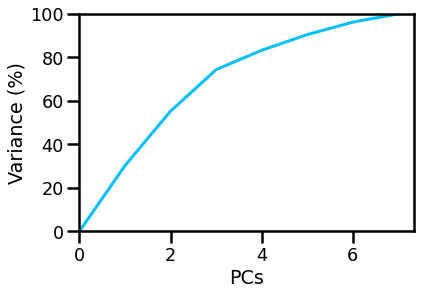

In [31]:
var = modelpca.explainedVariance.cumsum()
sns.set_context(context='poster', font_scale=0.8)
sns.lineplot(x=[i for i in range(8)], y=np.insert(var,0,0)*100, color='deepskyblue')
plt.xlabel('PCs')
plt.ylabel('Variance (%)')
plt.ylim(0,100)
plt.xlim(left=0)
plt.show()

## Export PCs to S3 as csv

In [24]:
transformed_final = transformed.select('path', 'label', 'pca')
transformed_pandas = transformed_final.toPandas()

In [25]:
transformed_pandas.to_csv('s3://<YOUR_BUCKET>/<YOUR_DIRECTORY>/PCA_output_7_PCs.csv', index=False)